In [3]:
import numpy as np
from utils import display_np_arrays_as_images

In [4]:
display_np_arrays_as_images()

In [5]:
img = np.load('test_images.npy', allow_pickle=False)
print(img.shape, img.dtype) # b h w c

(6, 96, 96, 3) float64


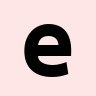

In [6]:
# first batch image
img[0]

In [9]:
!pip install einops
from einops import rearrange, reduce, repeat

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


     |████████████████████████████████| 43 kB 2.1 MB/s  eta 0:00:01


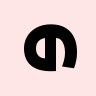

In [10]:
rearrange(img[0], 'h w c -> w h c')

### Composition

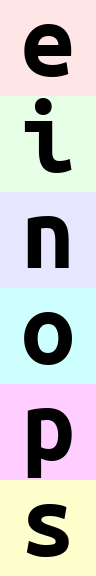

In [11]:
rearrange(img, 'b h w c -> (b h) w c')

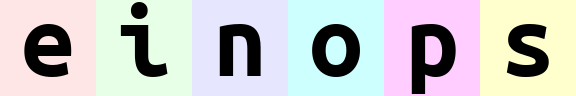

In [12]:
rearrange(img, 'b h w c -> h (b w) c')

In [13]:
rearrange(img, "b h w c -> h (b w) c").shape


(96, 576, 3)

In [14]:
rearrange(img, "b h w c -> (b h w c)").shape

(165888,)

### Decomposition

Decomposition is the inverse process by representing an axis as a combination of new axes


In [15]:
rearrange(img, '(b1 b2) h w c -> b1 b2 h w c', b1=2).shape

(2, 3, 96, 96, 3)

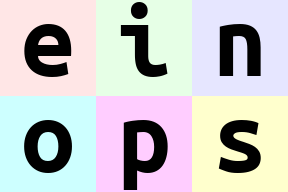

In [16]:
rearrange(img, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=2)

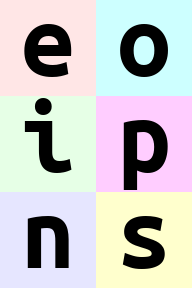

In [17]:
rearrange(img, '(b1 b2) h w c -> (b2 h) (b1 w) c', b1=2)

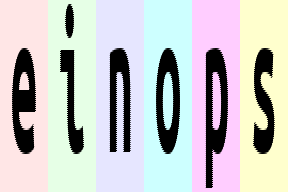

In [32]:
# move part of width dimension to height.
# we should call this width-to-height as image width shrunk by 2 and height doubled.
# but all pixels are the same!
rearrange(img, 'b h (w w2) c -> (h w2) (b w) c', w2=2)

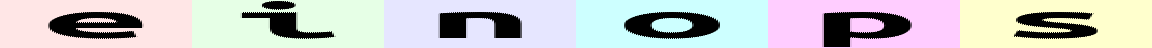

In [33]:
# height-to-width
rearrange(img, 'b (h h2) w c -> h (b w h2) c', h2=2)

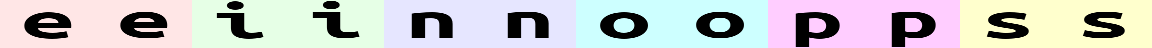

In [34]:
# Compare with the above
rearrange(img, 'b (h h2) w c -> h (b h2 w) c', h2=2)

### Order of axes matters

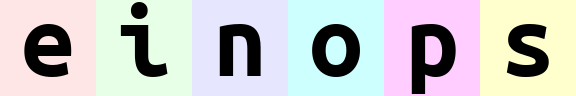

In [35]:
rearrange(img, 'b h w c -> h (b w ) c')

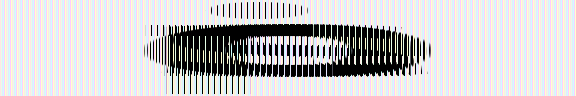

In [38]:
# order of axes in composition is different
# rule is just as for digits in the number: leftmost digit is the most significant,
# while neighboring numbers differ in the rightmost axis.

# you can also think of this as lexicographic sort
rearrange(img, 'b h w c -> h (w b) c')

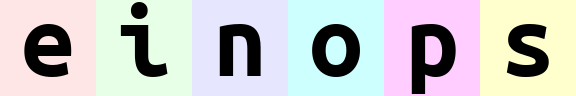

In [39]:
rearrange(img, '(b1 b2) h w c -> h (b1 b2 w) c', b1=2)

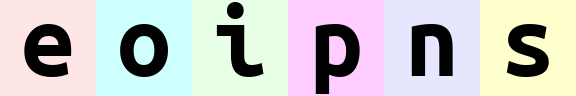

In [40]:
rearrange(img, '(b1 b2) h w c -> h (b2 b1 w) c', b1=2)

### Reduce
In einops-land you don't need to guess what happened

x.mean(-1)
Because you write what the operation does

reduce(x, 'b h w c -> b h w', 'mean')
if axis is not present in the output — you guessed it — axis was reduced.

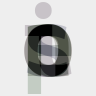

In [42]:
reduce(img, 'b h w c -> h w c', 'mean') # average over batch

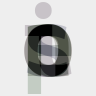

In [43]:
img.mean(axis=0) # similar to the above

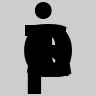

In [44]:
# There are also min, max, sum, prod
reduce(img, 'b h w c -> h w', 'min')

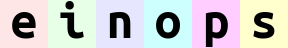

In [45]:
# mean-pooling 2x2 kernel
# image is split into 2x2 patches, and then each patch is averaged
reduce(img, 'b (h h2) (w w2) c -> h (b w) c', 'mean', h2=2, w2=2)

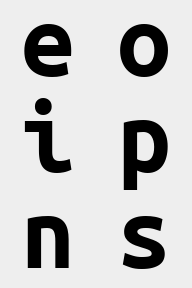

In [46]:
reduce(img, '(b1 b2) h w c -> (b2 h) (b1 w)', 'mean', b1=2)

### Stack & Concatenate

In [47]:
x = list(img)
print(type(x), "with", len(x), "tensors of shape", x[0].shape)

<class 'list'> with 6 tensors of shape (96, 96, 3)


In [48]:
# that's how we can stack inputs
# "list axis" becomes first ("b" in this case), and we left it there
rearrange(x, 'b h w c -> b h w c')

<array of shape (6, 96, 96, 3)>


In [49]:
# but new axis can appear in the other place:
rearrange(x, "b h w c -> h w c b").shape

(96, 96, 3, 6)

In [50]:
# that's equivalent to numpy stacking, but written more explicitly
np.array_equal(rearrange(x, "b h w c -> h w c b"), np.stack(x, axis=3))

True

In [55]:
# ... or we can concatenate along axes
rearrange(x, "b h w c -> h (b w) c").shape

(96, 576, 3)

In [56]:
# which is equivalent to concatenation
np.array_equal(rearrange(x, "b h w c -> h (b w) c"), np.concatenate(x, axis=1))

True